# Face Recognition using PCA,LDA,KNN manually implemented


## Names: 
#### Zyad Shokry Abozaid 3517
#### Mohamed Mohy 3233
#### Kareem Ahmed Abdel-Salam 3356

#### Problem Statement :

We intend to perform face recognition. Face recognition means that for a given image
you can tell the subject id. Our database of subject is very simple. It has 40 subjects.

#### 1-Downloading the dataset

We will use ORL dataset:

http://www.cl.cam.ac.uk/research/dtg/attarchive/facedatabase.html

The data is available at the following link:

http://www.cl.cam.ac.uk/Research/DTG/attarchive/pub/data/att_faces.tar.Z

The dataset has 10 images per 40 subjects.
Every image is a grayscale image of size 92x112.

intial setup,imports and functions declaration :

In [8]:
#initial imports
import matplotlib.image as img
import numpy as np
import math
from numpy import linalg as LA
import pickle
from pathlib import Path
from scipy.spatial import distance
import operator
import matplotlib.pyplot as plt
import faceRecognition

In [9]:
# =============================================================================
# SIMPLE CLASSIFIER ROUTINE
# =============================================================================


def classify(
    data_mat0,
    data_mat1,
    label_mat0,
    label_mat1,
    ):

    length = data_mat0.shape[0]
    map_ = np.zeros((1, length))
    label_mat_new = np.zeros((1, length))
    accuracy_mat = np.ones((1, length))

    for i in range(0, length):
        for j in range(0, length):
            map_[0, j] = distance.euclidean(data_mat1[i], data_mat0[j])
        arg = map_.argmin()
        label_mat_new[0, i] = label_mat0[arg]
        if label_mat_new[0, i] != label_mat1[i]:
            accuracy_mat[0, i] = 0

    return 100 * np.sum(accuracy_mat) / np.size(accuracy_mat)


In [10]:
# =============================================================================
# PROJECTION MATRIX ROUTINE
# =============================================================================

def getProj(data_matrix, alpha, str):

    isAlpha = False
    number = 0
    data_matrix_centered = data_matrix - np.mean(data_matrix, axis=0)
    data_matrix_cov = np.cov(data_matrix_centered, rowvar=False)
    (eigenValues, eigenVectors) = LA.eigh(data_matrix_cov)
    idx = eigenValues.argsort()[::-1]
    eigenValues = eigenValues[idx]
    eigenVectors = eigenVectors[:, idx]
    total = np.sum(eigenValues)

    while isAlpha == False:
        sum_eigVal = 0.0
        for i in range(eigenValues.size):
            sum_eigVal = sum_eigVal + eigenValues[i] / total
            number += 1
            if math.isclose(sum_eigVal, alpha) or sum_eigVal > alpha:
                isAlpha = True
                break

    projection_matrix = np.matrix([eigenVectors[n] for n in
                                  range(number)]).T

    if not Path(str + '.pickle').exists():
        with open(str + '.pickle', 'wb') as handle:
            pickle.dump(projection_matrix, handle,
                        protocol=pickle.HIGHEST_PROTOCOL)
    else:
        print ('Error.' + ' Another file with same name already found.')
    return projection_matrix


In [11]:
# =============================================================================
# PCA ROUTINE
# =============================================================================

def PCA_(
    data_matrix,
    proj_matrix,
    alpha,
    str,
    ):

    data_matrix_centered = data_matrix - np.mean(data_matrix, axis=0)
    if proj_matrix is None:
        projection_matrix = getProj(data_matrix, alpha, str)
    else:
        projection_matrix = proj_matrix

    rd_data_matrix = np.matmul(data_matrix_centered, projection_matrix)
    return rd_data_matrix



### 2-Generating the Data Matrix and the Label vector

In [12]:

# =============================================================================
# INITIAL SETUP
# =============================================================================

imgMat = np.zeros((0, 10304))
temp = np.arange(1, 41, 1)
label_matrix = np.array([[temp[i]] * 10 for i in range(temp.size)])
label_matrix = label_matrix.flatten()
#put folder name containing ORL dataset
#note that this is for linux directory system for windows use those lines with changes
#folder="C:\\FaceReco\\orl_faces\\"
# direction=folder+"s"+str(j)+"\\"
folder = 'orl_faces/'
for j in range(1, 41):
    direction = folder + 's' + str(j) + '/'
    for i in range(1, 11):
        directory = direction + str(i) + '.pgm'
        image = img.imread(directory).T
        imageVect = np.asmatrix(image.flatten())
        imgMat = np.concatenate((imgMat, imageVect))




### 3. Spliting the Dataset into Training and Test sets 

In [26]:
test_data_matrix = imgMat[0:400:2]
training_data_matrix = imgMat[1:400:2]

label_test = label_matrix[0:400:2]
label_training = label_matrix[1:400:2]

### 4. Classification using PCA

In [14]:
# =============================================================================
# COMPUTING ACCURACY FOR EACH ALPHA
# =============================================================================

# proj_data_mat=getProj(training_data_matrix,0.95,"proj_data_mat_0.95")

alpha = np.matrix([[0.8, 0.85, 0.9, 0.95]])

for k in range(alpha.size):
    with open('proj_data_mat_' + str(alpha[0, k]) + '.pickle', 'rb') as \
        handle:
        proj_data_mat = pickle.load(handle)
    training_data_matrix_rd = PCA_(training_data_matrix, proj_data_mat,
                                   alpha[0, k], '')
    test_data_matrix_rd = PCA_(test_data_matrix, proj_data_mat,
                               alpha[0, k], '')
    acc_prc = classify(training_data_matrix_rd, test_data_matrix_rd,
                       label_training, label_test)
    print ('For alpha: ' + str(alpha[0, k]) + ' accuracy percentage= ' \
        + str(acc_prc) + '%\n')

For alpha: 0.8 accuracy percentage= 93.0%

For alpha: 0.85 accuracy percentage= 95.5%

For alpha: 0.9 accuracy percentage= 97.0%

For alpha: 0.95 accuracy percentage= 97.5%



##  5-Classification using LDA

a- 
i.Calculate the mean vector for every class Mu1,Mu2,..., Mu40

In [15]:
#number of images in total
rows=400
#differenct people
number_of_classes=40
nImages_in_each_class=10
#dimentions of vector (image) before reduction
dimentions=10304
D=imgMat

#making an array to save means of each class (40,10304)
classes_means=np.zeros((number_of_classes,dimentions))

for i in range(number_of_classes):
    #adding evens because index of arrays start at zero not 1
    classes_means[i]=np.mean(test_data_matrix[i*5:i*5+5],axis=0)

ii. Replace B matrix by Sb

In [16]:
#finding Sb (replacement to B for higher no of classes) in LDA
#nk is number of samples in kth class
nk=nImages_in_each_class // 2 
#overall sample mean
#get mean of each column and result is 1 row and 10304(dimentions) columns
meu=np.mean(D,axis=0)
#initializing Sb
Sb=np.zeros((dimentions,dimentions))

for k in range(number_of_classes):
    diff_means=classes_means[k]-meu
    diff_means=np.reshape(diff_means,(1,10304) )
    dm_t=diff_means.transpose()
    B=np.matmul(dm_t,diff_means)
    Sb+=nk*B
#print(Sb.shape) #(10304, 10304)


iii. center class matrices Zi i=0,1,2...39

In [68]:
"""center class matrices Zi i=0,1,2...39 : """
Z=D
for i in range(number_of_classes):
    for j in range (nImages_in_each_class):
        if(j % 2 == 0):
            Z[i*10+j]-=classes_means[i][:]
#print("shape of Z:",Z.shape) #(400, 10304)

S within class scatter matrix

In [ ]:
"""within class scatter matrix S :"""
S=np.zeros((dimentions,dimentions))
S_initial=np.zeros((nImages_in_each_class // 2,dimentions))
for i in range (number_of_classes):
    for j in range (nImages_in_each_class // 1):
        if (j % 2== 0):    
            S_i=S_initial
            S_i[j // 2]+=Z[i*10+j]
    S_i=np.dot(S_i.T,S_i)
    S+=S_i

S inverse

In [ ]:
#S_inv=np.linalg.inv(S)
#S_inv= np.linalg.solve(S, np.identity(10304))
S_inv= np.linalg.pinv(S)

iv. getting eigenvectors and eigenvalues and using 39 dominant eigenvectors instead of one

In [ ]:
#Eigen vectors and values:
S_inv_mul_B=np.matmul(S_inv,Sb)
#commenting those because of high processing

eigenvals,eigenvecs = np.linalg.eig(S_inv_mul_B)
#sorting eigen values in descending order
sort_idx = np.argsort(eigenvals)[::-1]
eigenvals = eigenvals[sort_idx]
eigenvecs = eigenvecs[:,sort_idx]

#lamb=np.zeros(39)
u=eigenvecs[:,:39]
lamp=eigenvals[:39]

### b. Projecting the training set and test sets separately using same projection matrix U.

In [ ]:
#some error here
p_train=training_data_matrix.dot(u)  
p_test=test_data_matrix.dot(u)

In [ ]:
def getAccuracy(predictedClasses, label_vector): # check predicted classes for correctness
	correct = 0
	for x in range(len(predictedClasses)):
		if predictedClasses[x] is label_vector[x]:
			correct += 1
	return (correct/float(len(predictedClasses))) * 100.0

In [ ]:
def Knn(trainingSet,label_vector,test,k):
    distances =[]
    for x in range(len(trainingSet)): #calculating distance between test instance and all training data 
        distance = np.linalg.norm(np.subtract(test,trainingSet[x]))
        distances.append((label_vector[x],distance)) #storung the distance with the class of the training instance 
    distances.sort(key=operator.itemgetter(1)) #sorting distances array by the distance
    neighbors = []
    for x in range(k):
        neighbors.append(distances[x]) #get the K neighbors of the instance
    classes ={}
    for x in range(len(neighbors)): #check classes for the neighbors
        response= neighbors[x][0] 
        if response in classes:
            classes[response] += 1 #classVote found! increase voting by 1
        else:
            classes[response] = 1 #new classVote! add it to the dict
    sortedVotes = sorted(classes.items(), key=operator.itemgetter(1), reverse=True)#sort the class votes in decreasing order
    return sortedVotes[0][0] #return the most voted class number

In [ ]:
count=1
labelVector =[]
for x in range(40): #constructing the classes of each instance
    for j in range(5):
        labelVector.append(count)
    count= count+1
k=[1,3,5,7]
accuracy=[]
for i in range(4):
    list_of_predictions=[] 
    for x in range(200):    #test all the test_data_matrix
        list_of_predictions.append(Knn(training_data_matrix,labelVector,test_data_matrix[x],k[i]))
    accuracy.append(getAccuracy(list_of_predictions,labelVector))
    print(accuracy[i],"%")
plt.plot(k,accuracy)
plt.ylabel("accuracy LDA in %")
plt.xlabel("K")
plt.show

## 6-Classifier Tuning

#### a. Set the number of neighbors in the K-NN classifier to 1,3,5,7.
#### b. Tie breaking.
#### c. Ploting the performance measure (accuracy) against the K value.
#### This is done for PCA and LDA as well.

0.0 %
0.0 %
0.0 %
0.0 %


<function matplotlib.pyplot.show>

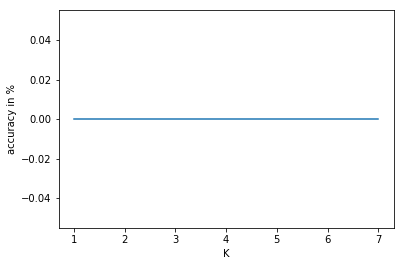

In [27]:

count=1
labelVector =[]
for x in range(40): #constructing the classes of each instance
    for j in range(5):
        labelVector.append(count)
    count= count+1

def getAccuracy(predictedClasses, label_vector): # check predicted classes for correctness
	correct = 0
	for x in range(len(predictedClasses)):
		if predictedClasses[x] is label_vector[x]:
			correct += 1
	return (correct/float(len(predictedClasses))) * 100.0

def Knn(trainingSet,label_vector,test,k):
    distances =[]
    for x in range(len(trainingSet)): #calculating distance between test instance and all training data 
        distance = np.linalg.norm(np.subtract(test,trainingSet[x]))
        distances.append((label_vector[x],distance)) #storung the distance with the class of the training instance 
    distances.sort(key=operator.itemgetter(1)) #sorting distances array by the distance
    neighbors = []
    for x in range(k):
        neighbors.append(distances[x]) #get the K neighbors of the instance
    classes ={}
    for x in range(len(neighbors)): #check classes for the neighbors
        response= neighbors[x][0] 
        if response in classes:
            classes[response] += 1 #classVote found! increase voting by 1
        else:
            classes[response] = 1 #new classVote! add it to the dict
    sortedVotes = sorted(classes.items(), key=operator.itemgetter(1), reverse=True)#sort the class votes in decreasing order
    return sortedVotes[0][0] #return the most voted class number
#list for getting the predictions for all test instances
#for x in range(200):    #test all the test_data_matrix
#    list_of_predictions.append(Knn(faceRecognition.training_data_matrix,labelVector,faceRecognition.test_data_matrix[x],3))
#print(getAccuracy(list_of_predictions,labelVector),"%")
k=[1,3,5,7]
accuracy=[]
for i in range(4):
    list_of_predictions=[] 
    for x in range(200):    #test all the test_data_matrix
        list_of_predictions.append(Knn(training_data_matrix,label_test,test_data_matrix[x],k[i]))
    accuracy.append(getAccuracy(list_of_predictions,label_test))
    print(accuracy[i],"%")
plt.plot(k,accuracy)
plt.ylabel("accuracy in %")
plt.xlabel("K")
plt.show

(200,)
0.0 %
0.0 %
0.0 %
0.0 %


<function matplotlib.pyplot.show>

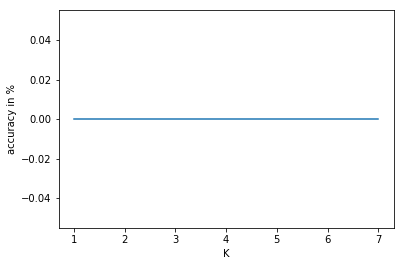

In [32]:

count=1
labelVector =[]
for x in range(40): #constructing the classes of each instance
    for j in range(5):
        labelVector.append(count)
    count= count+1

def getAccuracy(predictedClasses, label_vector): # check predicted classes for correctness
	correct = 0
	for x in range(len(predictedClasses)):
		if predictedClasses[x] is label_vector[x]:
			correct += 1
	return (correct/float(len(predictedClasses))) * 100.0
def Knn(trainingSet,label_vector,test,k):
    distances =[]
    for x in range(len(trainingSet)): #calculating distance between test instance and all training data 
        distance = np.linalg.norm(np.subtract(test,trainingSet[x]))
        distances.append((label_vector[x],distance)) #storung the distance with the class of the training instance 
    distances.sort(key=operator.itemgetter(1)) #sorting distances array by the distance
    neighbors = []
    for x in range(k):
        neighbors.append(distances[x]) #get the K neighbors of the instance
    classes ={}
    for x in range(len(neighbors)): #check classes for the neighbors
        response= neighbors[x][0] 
        if response in classes:
            classes[response] += 1 #classVote found! increase voting by 1
        else:
            classes[response] = 1 #new classVote! add it to the dict
    sortedVotes = sorted(classes.items(), key=operator.itemgetter(1), reverse=True)#sort the class votes in decreasing order
    return sortedVotes[0][0] #return the most voted class number
#list for getting the predictions for all test instances
#for x in range(200):    #test all the test_data_matrix
#    list_of_predictions.append(Knn(faceRecognition.training_data_matrix,labelVector,faceRecognition.test_data_matrix[x],3))
#print(getAccuracy(list_of_predictions,labelVector),"%")
k=[1,3,5,7]
accuracy=[]
print(label_training.shape)
for i in range(4):
    list_of_predictions=[] 
    for x in range(200):    #test all the test_data_matrix
        list_of_predictions.append(Knn(training_data_matrix,label_training,test_data_matrix[x],k[i]))
    accuracy.append(getAccuracy(list_of_predictions,label_test))
    print(accuracy[i],"%")
plt.plot(k,accuracy)
plt.ylabel("accuracy in %")
plt.xlabel("K")
plt.show